In [1]:
import os
import time
import logging

import numpy as np
import pandas as pd
import yaml
from watchdog.observers import Observer

from dasly.master import Dasly
from dasly.utils import (
    assign_id_df,
    save_lines_csv,
    HDF5EventHandler,
    add_subtract_dt,
    get_date_time,
    gen_id
)

# Load the parameters
yaml_path = '../config_iceland.yml'
with open(yaml_path, 'r') as file:
    params = yaml.safe_load(file)

In [2]:
file_path = '/mnt/Datastore/usr/kptruong/dasly_repo/data/svalbard/20220822/dphi/122829.hdf5'

In [3]:
# Get the experiment directory, date, and time
date_str, time_str = get_date_time(file_path)

# Run the dasly_core
first_file_dt = add_subtract_dt(
    f'{date_str} {time_str}',
    params['hdf5_file_length'] - params['dasly']['batch']
)

s_rate = 0.25
das = Dasly()
das.load_data(
    folder_path='/mnt/Datastore/usr/kptruong/dasly_repo/data/svalbard',
    start=first_file_dt,
    duration=params['dasly']['batch'],
    start_exact_second=params['start_exact_second'],
    integrate=params['integrate'],
    chIndex=np.arange(round(5000 * s_rate), round(85000 * s_rate)),
    reset_channel_idx=False
)

3 files, from 20220822 122809 to 20220822 122829


vmin: -1.6e-08, vmax: 1.6e-08


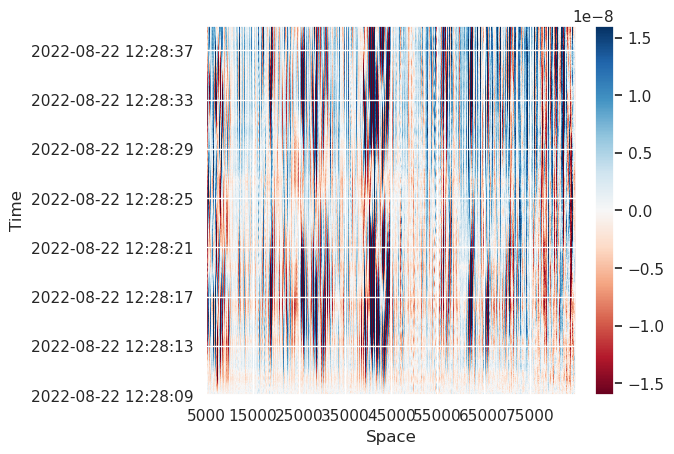

In [4]:
das.heatmap()

Signal updated with band-pass filter.
vmin: -2.22e-10, vmax: 2.22e-10


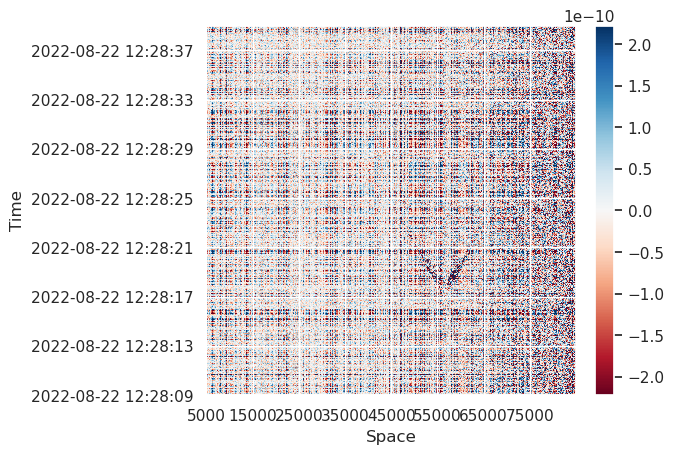

In [5]:
# forward Gaussian smoothing
###########################################################################
das.bandpass_filter(
    low=params['bandpass_filter']['low'],
    high=params['bandpass_filter']['high']
)
das.heatmap()

vmax: 2.22e-10


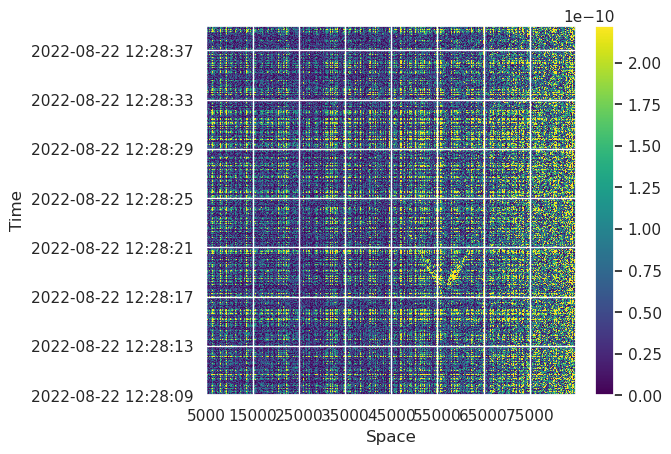

In [6]:
das.signal = np.abs(das.signal)
das.heatmap()

Signal updated with new temporal sampling rate 25 and new spatial sampling rate 0.010.
vmax: 1.34e-10


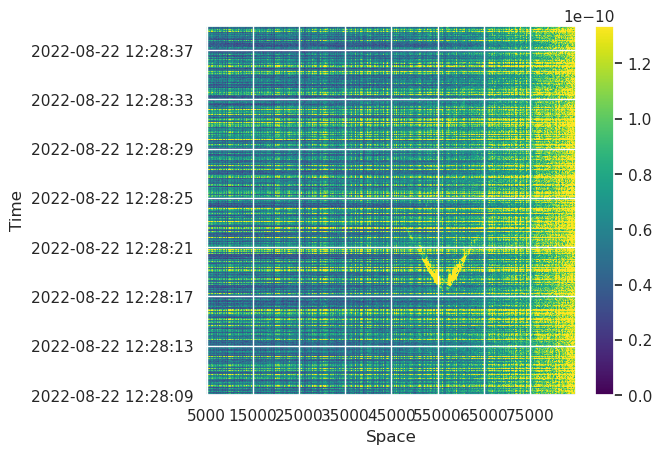

In [7]:
das.sample(
    meters=params['sample']['meters'],
    seconds=params['sample']['seconds']
)
das.heatmap()

Signal updated with Gaussian smoothing.
vmax: 1.16e-10


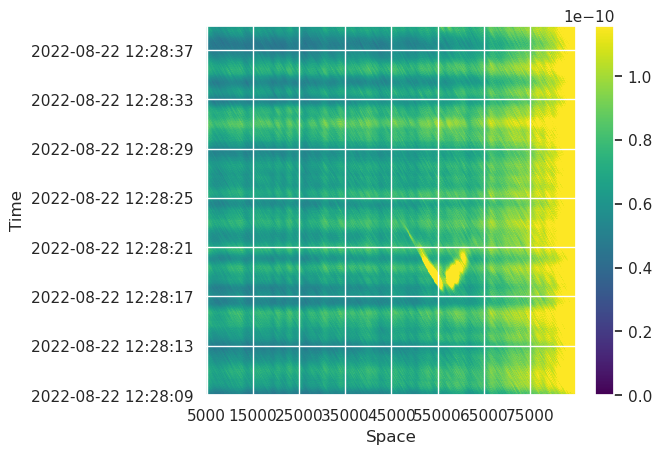

In [8]:
das.gaussian_smooth(
    s1=params['gaussian_smooth']['s1'],
    s2=params['gaussian_smooth']['s2'],
    std_s=params['gaussian_smooth']['std_s'],
    unit=params['gaussian_smooth']['unit']
)
das.heatmap()

Signal updated with Sobel filter.
vmax: 1.83e-11


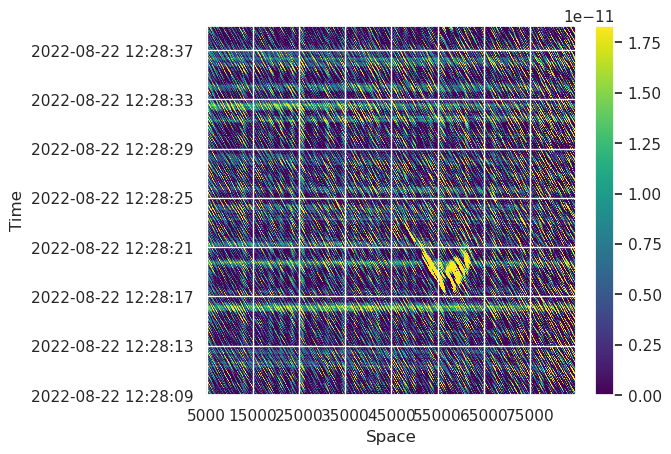

In [9]:
das.sobel_filter()
das.heatmap()

Signal updated with binary transform with threshold 2.5e-11.


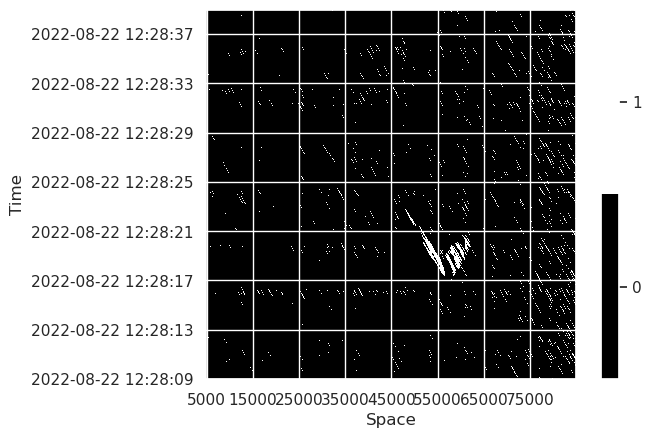

In [10]:
das.binary_transform(threshold=params['binary_threshold'])
das.heatmap()

7 lines are detected.


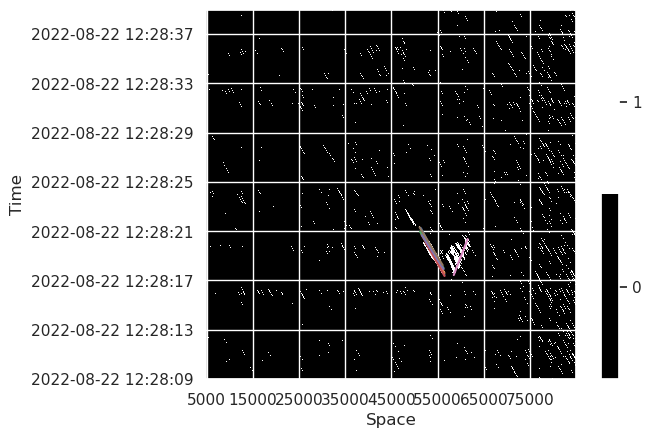

In [11]:
das.hough_transform(
    target_speed=((params['gaussian_smooth']['s1']
                    + params['gaussian_smooth']['s2']) / 2),
    speed_res=params['hough_transform']['speed_res'],
    length_meters=params['hough_transform']['length_meters'],
    threshold_percent=params['hough_transform']['threshold_percent'],
    max_line_gap_percent=params['hough_transform']['max_line_gap_percent'],
    speed_unit=params['hough_transform']['speed_unit']
)
das.heatmap()

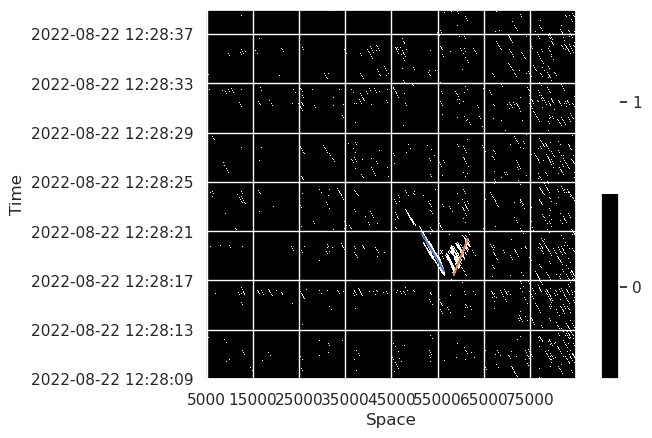

In [12]:
das.dbscan(eps_seconds=params['dbscan_eps_seconds'])  # group close lines
das.heatmap()

In [13]:
das.lines_df

,speed_kmh,speed_ms,s,t,s1,t1,s2,t2,s1_edge,t1_edge,...,x1,y1,x2,y2,x1_edge,y1_edge,x2_edge,y2_edge,y1_edge_ext,y2_edge_ext
0,-5727.272727,-1590.909091,-4900.0,3.08,56400.0,2022-08-22 12:28:17.760,51500.0,2022-08-22 12:28:20.840,70336.363636,2022-08-22 12:28:09,...,514.0,219.0,465.0,296.0,653.363636,0.0,176.727273,749.0,1026.714286,-228.857143
1,3698.630137,1027.397260,3000.0,2.92,58500.0,2022-08-22 12:28:17.440,61500.0,2022-08-22 12:28:20.360,49828.767123,2022-08-22 12:28:09,...,535.0,211.0,565.0,284.0,448.287671,0.0,756.095890,749.0,-1090.833333,853.400000


In [1]:
import pandas as pd
len(pd.DataFrame())

0

In [3]:
table = 'iceland'
date_str = '20220822'
time_str = '120909'


query = (
    f'SELECT * FROM {table}' +
    f" WHERE batch_id = '{date_str} {time_str}';"
)
query


"SELECT * FROM iceland WHERE batch_id = '20220822 120909';"